<a href="https://colab.research.google.com/github/vitorgaboardi/data-science/blob/master/Whatsapp_Group_Chat_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Whatsapp Group Chat Data Analysis using python.

Reference: https://github.com/kurasaiteja/Whatsapp-Analysis


In [16]:
!pip install emoji

In [17]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
% matplotlib inline

In [18]:
! git clone https://github.com/amueller/word_cloud.git
% cd word_cloud
! pip install .

Cloning into 'word_cloud'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 6213 (delta 43), reused 58 (delta 7), pack-reused 6089
Receiving objects: 100% (6213/6213), 113.63 MiB | 32.40 MiB/s, done.
Resolving deltas: 100% (3651/3651), done.
/content/word_cloud/word_cloud
Processing /content/word_cloud/word_cloud
  Created wheel for wordcloud: filename=wordcloud-1.8.0.post1+g5f23ed4-cp36-cp36m-linux_x86_64.whl size=338650 sha256=d2504017afd2d66b93c4c02b794aa810be608101d27eca3b6aeec71946c39b62
  Stored in directory: /tmp/pip-ephem-wheel-cache-t_9yy54w/wheels/25/0d/29/49e0d7b13f38317e6d03d9911d1fe7c3b1e8ba9799fc28befd
Successfully built wordcloud
  Found existing installation: wordcloud 1.8.0.post1+g5f23ed4
    Uninstalling wordcloud-1.8.0.post1+g5f23ed4:
      Successfully uninstalled wordcloud-1.8.0.post1+g5f23ed4


# **Data Preparation:**







In [19]:
def startsWithDateAndTimeAndroid(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

def startsWithDateAndTimeios(s):
    pattern = '^\[([0-9]+)([\/-])([0-9]+)([\/-])([0-9]+)[,]? ([0-9]+):([0-9][0-9]):([0-9][0-9])?[ ]?(AM|PM|am|pm)?\]' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [20]:
def FindAuthor(s):
  s=s.split(":")
  if len(s)==2:
    return True
  else:
    return False

In [21]:
def getDataPointAndroid(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(':') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

def getDataPointios(line):
	splitLine = line.split('] ')
	dateTime = splitLine[0]
	if ',' in dateTime:
		date, time = dateTime.split(',')
	else:
		date, time = dateTime.split(' ')
	message = ' '.join(splitLine[1:])
	if FindAuthor(message):
		splitMessage = message.split(':')
		author = splitMessage[0]
		message = ' '.join(splitMessage[1:])
	else:
		author = None
	if time[5]==":":
		time = time[:5]+time[-3:]
	else:
		if 'AM' in time or 'PM' in time:
			time = time[:6]+time[-3:]
		else:
			time = time[:6]
	return date, time, author, message


If you get a **Value Error** after running the below cell , it may be due to different format of date.

Try replacing %d-%m-%Y with %m-%d-%Y and replacing %d-%m-%y with %m-%d-%y and similarly for / too.

In [22]:
def dateconv(date):
  year=''
  if '-' in date:
    year = date.split('-')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d-%m-%Y").strftime("%Y-%m-%d")
    elif len(year) ==2:
      return datetime.datetime.strptime(date, "[%d-%m-%y").strftime("%Y-%m-%d")
  elif '/' in date:
    year = date.split('/')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d/%m/%Y").strftime("%Y-%m-%d")
    if len(year) ==2:
      return datetime.datetime.strptime(date, "[%d/%m/%y").strftime("%Y-%m-%d")

In [23]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

Change file path in the below cell

In [24]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = '/content/chat_pos.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    device=''
    first=fp.readline()
    #print(first)
    if '[' in first:
      device='ios'
    else:
      device="android"
    fp.readline() 
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        if device=="ios":
          line = line.strip()
          if startsWithDateAndTimeios(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointios(line)
            messageBuffer.append(message)
          else:
            line= (line.encode('ascii', 'ignore')).decode("utf-8")
            if startsWithDateAndTimeios(line):
              if len(messageBuffer) > 0:
                parsedData.append([date, time, author, ' '.join(messageBuffer)])
              messageBuffer.clear()
              date, time, author, message = getDataPointios(line)
              messageBuffer.append(message)
            else:
              messageBuffer.append(line)
        else:
          line = line.strip()
          if startsWithDateAndTimeAndroid(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointAndroid(line)
            messageBuffer.append(message)
          else:
            messageBuffer.append(line)



In [25]:
if device =='android':
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.dropna()
        df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
else:
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
        df = df.dropna()
        df["Date"] = df["Date"].apply(dateconv)
        df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
        df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

# Anonymizing the data - each author will have one specific number
df.Author.unique()
dic_author = {}
count = 0

for author in df.Author.unique():
  dic_author[author] = count
  count+=1

df.Author = df.Author.replace(dic_author)

# Change: Time considering only hours and minutos, not seconds.
df['Time'] = df['Time'].str[:-3]

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11348 entries, 2 to 11506
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      11348 non-null  datetime64[ns]
 1   Time      11348 non-null  object        
 2   Author    11348 non-null  int64         
 3   Message   11348 non-null  object        
 4   emoji     11348 non-null  object        
 5   urlcount  11348 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 620.6+ KB


# Group Wise Stats.

In [27]:
total_messages = df.shape[0]
print(total_messages)

11348


Let us now find out the total Media Messages

In [28]:
media_messages = df[df['Message'] == ' imagem ocultada'].shape[0]
print(media_messages)

443


In [29]:
emojis = sum(df['emoji'].str.len())
print(emojis)

2241


In [30]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()


In [31]:
links = np.sum(df.urlcount)

In [32]:
print("Group Wise Stats")
print("Messages:",total_messages)
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

Group Wise Stats
Messages: 11348
Media: 443
Emojis: 2241
Links: 8


## Let us Separate the media messages and text messages

In [33]:
link_messages= df[df['urlcount']>0]
deleted_messages=df[(df["Message"] == " Você apagou essa mensagem.")| (df["Message"] == " Essa mensagem foi apagada.")|(df["Message"] == " Você apagou essa mensagem.")]
media_messages_df = df[(df['Message'] == ' imagem ocultada')|(df['Message'] == ' ‎vídeo omitido')|(df['Message'] == ' figurinha omitida')]
messages_df = df.drop(media_messages_df.index)
messages_df = messages_df.drop(deleted_messages.index)
messages_df = messages_df.drop(link_messages.index)

In [34]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10878 entries, 2 to 11506
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      10878 non-null  datetime64[ns]
 1   Time      10878 non-null  object        
 2   Author    10878 non-null  int64         
 3   Message   10878 non-null  object        
 4   emoji     10878 non-null  object        
 5   urlcount  10878 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 594.9+ KB


It might be interesting to count the number of letters and words used by each author in each message. So, let us add 2 new columns to the data frame called “Letter_Count” and “Word_Count”, using the following code:

In [35]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

In [36]:
messages_df.head(2)

,Date,Time,Author,Message,emoji,urlcount,Letter_Count,Word_Count,MessageCount
2,2018-12-17,16:15,0,Taí,[],0,4,2,1
3,2018-12-17,16:17,1,👍🏻👍🏻,"[👍🏻, 👍🏻]",0,5,2,1


In [37]:
messages_df["emojicount"]= df['emoji'].str.len()

#Author wise stats

In [38]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(link_messages[link_messages['Author'] == l[i]]["urlcount"])   
  print('Links Sent', links)   
  print()

Stats of 0 -
Messages Sent 3181
Words per message 6.321282615529707
Media Messages Sent 190
Emojis Sent 621
Links Sent 2

Stats of 1 -
Messages Sent 1873
Words per message 7.093432995194875
Media Messages Sent 72
Emojis Sent 259
Links Sent 0

Stats of 2 -
Messages Sent 1168
Words per message 5.117294520547945
Media Messages Sent 75
Emojis Sent 158
Links Sent 0

Stats of 3 -
Messages Sent 4656
Words per message 4.507517182130584
Media Messages Sent 127
Emojis Sent 1203
Links Sent 6



# Most used Emoji in Group

# Emoji Stats

### Unique emojis used in group

In [39]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

49


### Most used emoji

In [40]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('😂', 535), ('👍🏻', 357), ('👍', 351), ('👏🏻', 345), ('👏', 334), ('🙌', 126), ('🙌🏻', 58), ('🤔', 17), ('🤞🏻', 10), ('🤦🏻\u200d♂', 10), ('🙏🏻', 9), ('😁', 7), ('😭', 6), ('👏🏼', 6), ('💪🏻', 5), ('😄', 5), ('🙏', 5), ('👀', 4), ('😅', 4), ('😊', 3), ('🍺', 3), ('😕', 3), ('😔', 3), ('🍻', 3), ('😰', 2), ('🔪', 2), ('☝🏻', 2), ('💸', 2), ('😬', 2), ('🤣', 2), ('🤦🏻\u200d♂️', 2), ('❣', 1), ('😏', 1), ('👎🏻', 1), ('😎', 1), ('😢', 1), ('💩', 1), ('🙂', 1), ('🐌', 1), ('😳', 1), ('🤢', 1), ('❤', 1), ('😀', 1), ('📈', 1), ('☺', 1), ('😞', 1), ('🤦\u200d♂', 1), ('\U0001f9be', 1), ('☀️', 1)]


In [41]:
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,😂,535
1,👍🏻,357
2,👍,351
3,👏🏻,345
4,👏,334
5,🙌,126
6,🙌🏻,58
7,🤔,17
8,🤞🏻,10
9,🤦🏻‍♂,10


We can see '😂 '   dominates the list.

### Emoji distribution visualisation

In [42]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### Person Wise Emoji Distribution

In [43]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Emoji Distribution for 0


Emoji Distribution for 1


Emoji Distribution for 2


Emoji Distribution for 3


# Some more Stats

### **Day wise Distribution**

In [44]:
def f(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(f)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

In [45]:
fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=False
)
fig.show()

### **Number of messages as times move on**

In [46]:
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount")
fig.update_xaxes(nticks=20)
fig.show()

In [47]:
date_df["rolling"] = date_df["MessageCount"].rolling(30).mean()
fig = px.line(date_df, x="Date", y="rolling")
fig.update_xaxes(nticks=20)
fig.show()

### **Chatter**

In [48]:
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="MessageCount", color='Author', orientation="h",
             color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta"],
             title="Explicit color sequence"
            )

fig.show()

### **When are the group members most active?**

Text(0, 0.5, 'Time')

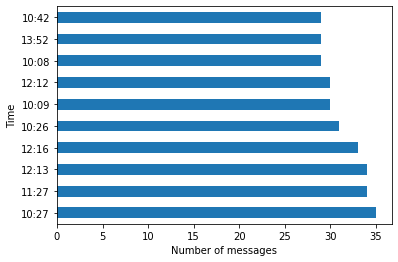

In [49]:
messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

### **The most happening day was -**

2019-05-05    192
2019-10-08    168
2020-03-22    160
2019-04-26    158
2019-07-01    139
             ... 
2019-05-18      1
2020-08-15      1
2020-01-01      1
2019-04-17      1
2020-05-27      1
Name: Date, Length: 400, dtype: int64


Text(0, 0.5, 'Date')

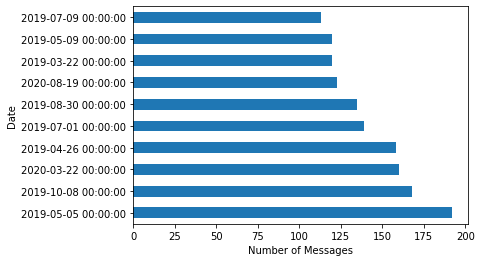

In [50]:
messages_df['Date'].value_counts().head(10).plot.barh()
print(messages_df['Date'].value_counts())
plt.xlabel('Number of Messages')
plt.ylabel('Date')

### **Word Cloud**

In [51]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 276363 words in all the messages.


In [52]:
  stopwords = set(STOPWORDS)
  stopwords.update(["o", "e", "que", "é", "em", "já", "q","se","de","a","aí","tô","tá","mas","para","tem","um","tá","não","Kkk","Kkkk","Kkkkk","lá"])
  # Generate a word cloud image
  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  # Display the generated image:
  # the matplotlib way:
  
  #plt.figure( figsize=(10,5))
  #plt.imshow(wordcloud, interpolation='bilinear')
  #plt.axis("off")
  #plt.show()